Projekt numer 3 - Remigiusz Kamiński

Rosja vs Ukraina

WSTĘP:

Jako temat tej pracy wybrałem ostatnio gorący temat jakim jest wojna na ukrainie i do tego użyłem tagów #ukraine jak i #russia. Jeśli chodzi o daną sytuacje oczywiście jest ona powiązana z polityką jak i wojną. Konfilkt ten zaczął się 24 lutego 2022 i na ten moment (czerwiec 2023) trwa dalej i nie wygląda na to, że ma się zakończyć w najbliższym czasie.

Dane zostały pobrane za pomocą paczki snscrape. Każdy z hasztagów otrzymał około 10000 tweetów i całość sięga mniej więcej od dnia dzisiejszego do 100 dni wstecz. Dane są w języku angielskim.

W poniższym kodzie pokaże jak te dane zostały pobrane:


In [ ]:
import snscrape.modules.twitter as sntwitter
from datetime import datetime, timedelta

hashtag = "russia"
hashtag2 = "ukraine"

lang = "en"
tweetsPerDay = 100
maxTotalTweets = 32000


def downloadTweets(maxTotalTweets, tweetsPerDay, hashtag, lang):
    
    totalTweets = 0
    totalTweetsDay = 0
    tweets = []
    
    daysToProcess = generateDaysToProcess(maxTotalTweets, tweetsPerDay)

    for day in daysToProcess:
        if totalTweets >= maxTotalTweets:
                print("Max total tweets reached")
                print("Total tweets: " + str(totalTweets))
                break
                
        for tweet in sntwitter.TwitterHashtagScraper(hashtag + " lang:" + lang + " since:" + str(day) + " until:" + str(day + timedelta(days=1))).get_items():
                 
                tweets.append(str(tweet.date.date())+", "+str(tweet.rawContent).replace("\n", " ")+"\n")
                totalTweets += 1
                totalTweetsDay += 1
    
                if totalTweetsDay >= tweetsPerDay:
                    totalTweetsDay = 0
                    print("Total tweets: " + str(totalTweets))
                    break
    return tweets

def saveTweets(filename, tweets):
    with open (filename, "w", encoding="utf-8") as file:
        for tweet in tweets:
            file.write(tweet + "\n")

def generateDaysToProcess(maxTotalTweets, tweetsPerDay):
    daysToProcess = []
    for i in range(maxTotalTweets//tweetsPerDay):
        daysToProcess.append((datetime.now() - timedelta(days=i)).date())
    return daysToProcess

def main():
    saveTweets("tweetsRussia.txt", downloadTweets(maxTotalTweets, tweetsPerDay, hashtag, lang))
    saveTweets("tweetsUkraine.txt", downloadTweets(maxTotalTweets, tweetsPerDay, hashtag2, lang))

if __name__ == '__main__':
    main()

Następnie nastąpiła pora na preprocessing, kod poniżej wykonuje takie czynności jak:

Usuwa znaki # z tweetów.
Usuwa nazwy użytkowników wspominanych w danych tweetach.
Usuwa linki.
Zmienia tekst na małe litery oraz zmienia je w pojedyncze słowa.
Usuwa niepotrzebne znaki interpunkcyjne, nawiasy oraz znaki specjalne jak i treści z nawiasów.
Usuwa puste słowa oraz na koniec pobiera popularne stop words i filtruje z nich te tweety.



In [ ]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')


def preprocessTweet(tweet):
    tweet = re.sub(r'^\d{4}-\d{2}-\d{2}, ', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'https?://\S+', '', tweet)
    tweet = tweet.lower()
    words = tweet.split()
    words = [re.sub(r'&amp;', '', word) for word in words]
    words = [re.sub(r'(?<=\w)[^\s\w](?![^\s\w])', '', word) for word in words]
    words = [re.sub(r'[|«»“”‘’,"–—…-]', '', word) for word in words]
    words = [re.sub(r'\([^)]*\)', '', word) for word in words]
    words = [re.sub(r'\.\.+$', '', word) for word in words]
    words = [re.sub(r'\.', '', word) for word in words]
    words = [re.sub(r'^[\(\[]', '', word) for word in words]
    words = [re.sub(r'[\)\]]$', '', word) for word in words]
    words = [word for word in words if word]
    preprocessedTweet = ' '.join(words)

    stop_words = list(nltk.corpus.stopwords.words('english'))
    words = word_tokenize(preprocessedTweet)
    words = [w for w in words if not w in stop_words]
    preprocessedTweet = ' '.join(words)


    return preprocessedTweet

def saveToFile(filename, tweets):
    with open (filename, "w", encoding="utf-8") as file:
        for tweet in tweets:
            file.write(tweet + "\n")

def getFile(filename):
    with open(filename, "r", encoding="utf-8") as file:
        tweets = file.readlines()
    return tweets

def preprocessFile(filename):
    tweets = getFile(filename)
    preprocessedTweets = [preprocessTweet(tweet) for tweet in tweets]
    return preprocessedTweets

def main():
    saveToFile("preprocessedRussia.txt", preprocessFile("tweetsRussia.txt"))
    saveToFile("preprocessedUkraine.txt", preprocessFile("tweetsUkraine.txt"))

if __name__ == '__main__':
    main()

Następnie przyszła pora na analize danych, która zajęła troche czasu wykonałem ją za pomocą paczek nltk oraz text2emotion. 

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from text2emotion import get_emotion

import nltk
nltk.download('vader_lexicon')


def analyzeSentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentimentScores = sid.polarity_scores(text)

    return sentimentScores

def getFile(filename):
    with open(filename, "r", encoding="utf-8") as file:
        tweets = file.readlines()
    return tweets

def analyzeEmotions(text):
    emotions = get_emotion(text)
    return emotions

def analyzeFile(filename):
    tweets = getFile(filename)
    sentimentScores = []
    emotions = []
    text = []
    for tweet in tweets:
        if tweet == '\n':
            continue
        if tweet[-1]=='\n':
            tweet = tweet[:-1]
        sentimentScores.append(analyzeSentiment(tweet))
        emotions.append(analyzeEmotions(tweet))
        text.append(tweet)

    return sentimentScores, emotions, text

def main():
    sentimentScores1, emotions1, text1 = analyzeFile("../dane/preprocessedRussia.txt")
    with open("sentimentScoresRussia.txt", "w", encoding="utf-8") as file:
        for i in range(len(text1)):
            file.write(str(text1[i])+", "+str(sentimentScores1[i])+", "+str(emotions1[i])+";"+'\n')


    sentimentScores2, emotions2, text2 = analyzeFile("../dane/preprocessedUkraine.txt")
    with open("sentimentScoresUkraine.txt", "w", encoding="utf-8") as file:
        for i in range(len(text2)):
            file.write(str(text2[i])+", "+str(sentimentScores2[i])+", "+str(emotions2[i])+";"+'\n')

if __name__ == "__main__":
    main()

Następnie przyszła pora to, aby podzielić te opinie na pozytywne i negatywne, wykorzystamy do tego compound score. Założyłem, że pozytywne skojrzanie będzie powyżej 0.1 a negatywne poniżej -0.1. Przedział pomiędzy został dla tak zwanych "neutralnych" wartości.

In [ ]:
import ast
def categorize(data):
    positiveTweets = []
    negativeTweets = []

    for tweet, sentiment_scores, emotions in data:
        compound_score = sentiment_scores['compound']
        if compound_score > 0.1:
            positiveTweets.append(tweet)
        elif compound_score < -0.1:
            negativeTweets.append(tweet)
    
    return positiveTweets, negativeTweets


def saveBothToFiles(positiveTweets, negativeTweets, filename1, filename2):
    with open(filename1, "w", encoding="utf-8") as file:
        file.writelines("\n".join(positiveTweets))

    with open(filename2, "w", encoding="utf-8") as file:
        file.writelines("\n".join(negativeTweets))

def parse_sentiment_scores(line):
    sentiment_start = line.index("{'neg':")
    sentiment_end = line.index("},") + 1
    emotions_start = line.index("{", sentiment_end)
    emotions_end = line.index("};", emotions_start) + 1

    sentiment_scores = ast.literal_eval(line[sentiment_start:sentiment_end])
    emotions = ast.literal_eval(line[emotions_start:emotions_end])

    return sentiment_scores, emotions


def parse_data(file):
    data = []
    for line in file:
        line = line.strip()
        if line:
            tweet_end = line.index(",")
            tweet = line[:tweet_end]
            scores, emotions = parse_sentiment_scores(line)

            data.append((tweet, scores, emotions))

    return data



def main():
    with open("sentimentScoresRussia.txt", "r", encoding="utf-8") as file:
        dataRussia = parse_data(file)

    with open("sentimentScoresUkraine.txt", "r", encoding="utf-8") as file:
        dataUkraine = parse_data(file)

    positiveTweetsRussia, negativeTweetsRussia = categorize(dataRussia)
    saveBothToFiles(positiveTweetsRussia, negativeTweetsRussia, "positiveTweetsRussia.txt", "negativeTweetsRussia.txt")

    positiveTweetsUkraine, negativeTweetsUkraine = categorize(dataUkraine)
    saveBothToFiles(positiveTweetsUkraine, negativeTweetsUkraine, "positiveTweetsUkraine.txt", "negativeTweetsUkraine.txt")


if __name__ == '__main__':
    main()

Teraz jak już mamy podzielone nasze dane przyszła pora na analize całościową. Zrobimy 6 chmur dla danych po preprocessingu oraz po pozytywnej i negatywnej zarówno dla #russia jak i #ukraine. Następnie zobaczymy dane słowa.

Na 1 ogień pójdą dane preprocessowane, następnie Rosja, a na koniec Ukraina.

World Clouds preprocessed Russia:


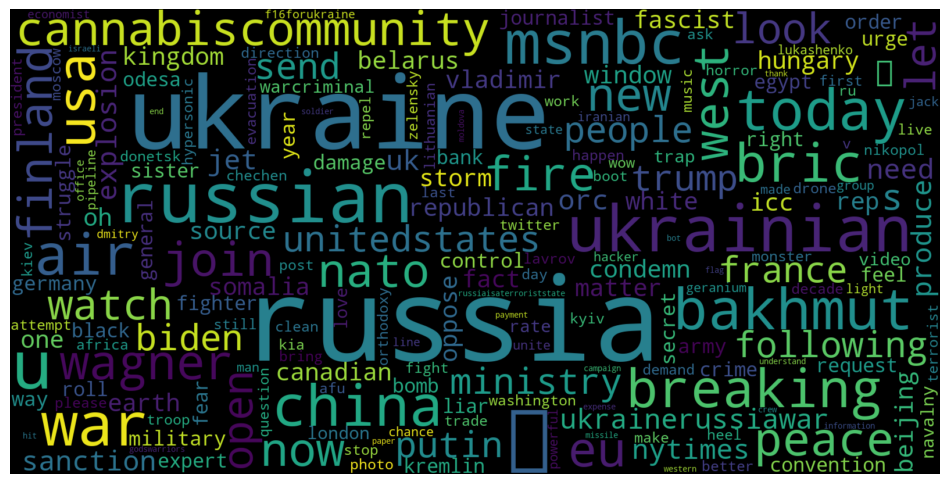

World Clouds preprocessed Ukraine:


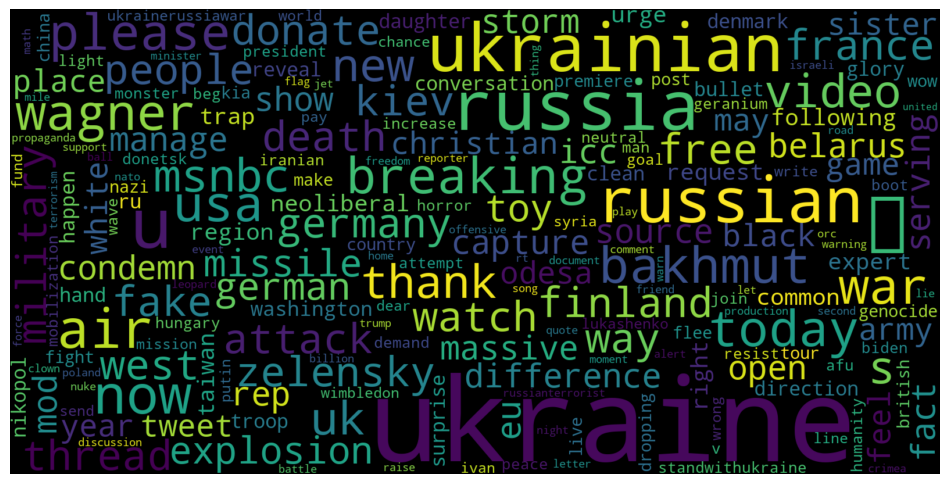

World Clouds positive Russia:


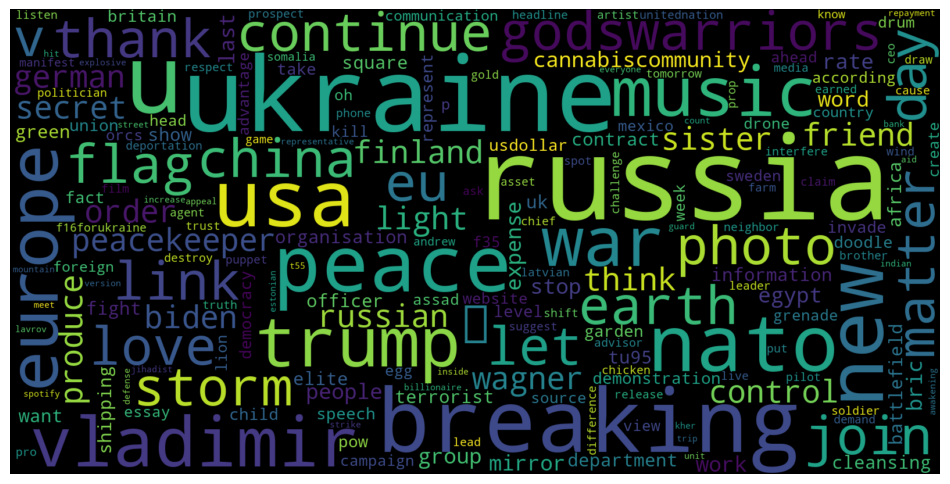

World Clouds negative Russia:


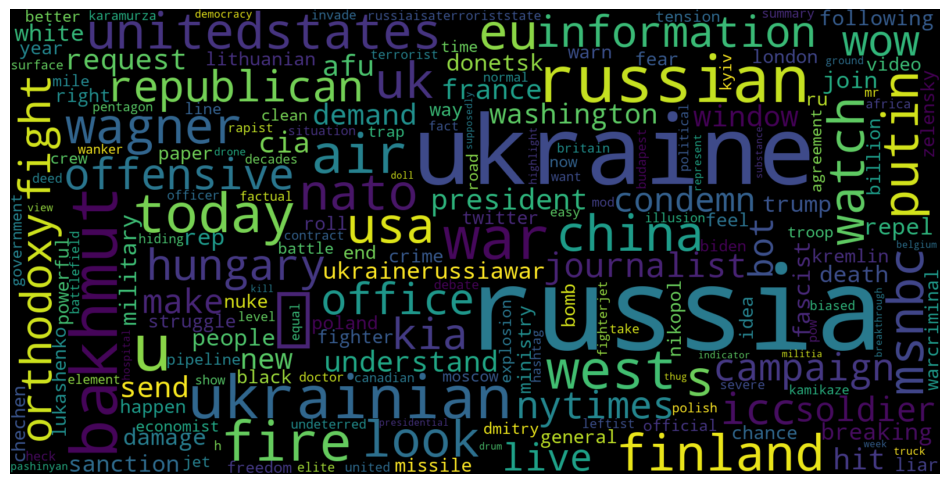

World Clouds positive Ukraine:


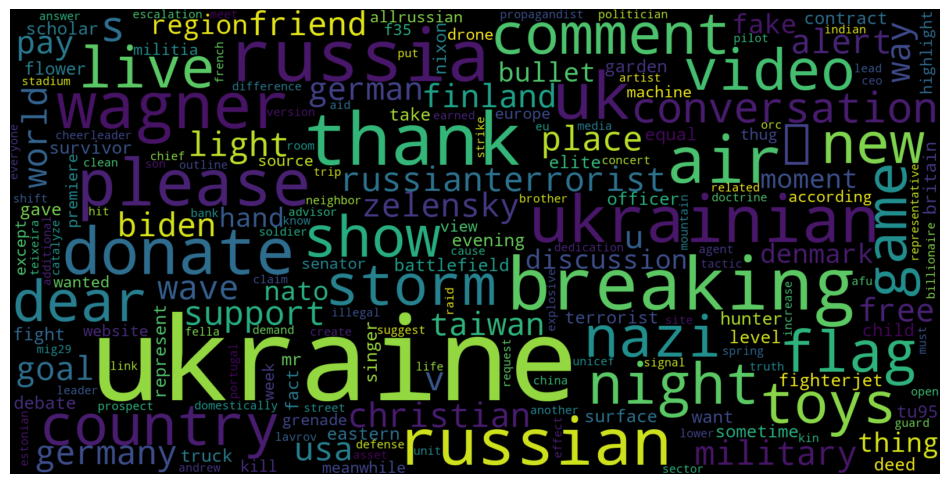

World Clouds negative Ukraine:


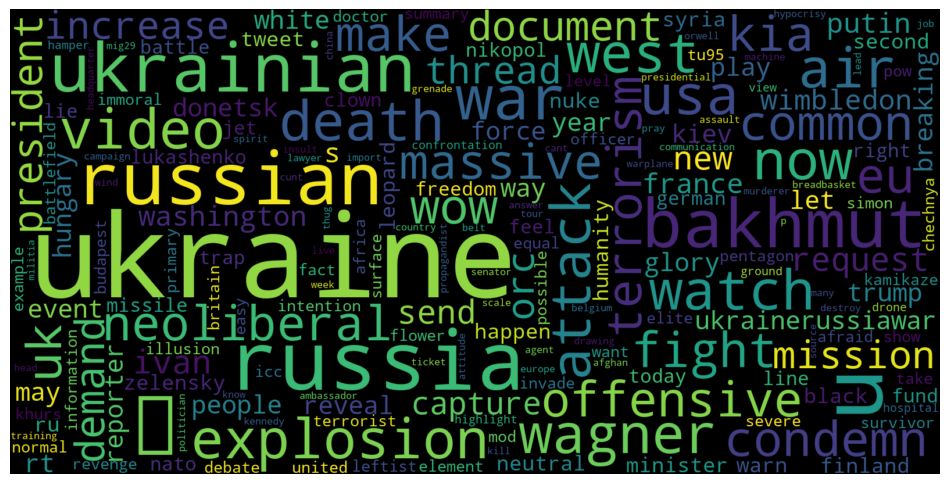

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

def generateWordCloud(text):
    words = word_tokenize(text)
    unique_words = set(words) 
    unique_text = ' '.join(unique_words)
    
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(unique_text)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def getData(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def main():
    print("World Clouds preprocessed Russia:")
    generateWordCloud(getData('../dane/preprocessedRussia.txt'))
    print("World Clouds preprocessed Ukraine:")
    generateWordCloud(getData('../dane/preprocessedUkraine.txt'))
    print("World Clouds positive Russia:")
    generateWordCloud(getData('positiveTweetsRussia.txt'))
    print("World Clouds negative Russia:")
    generateWordCloud(getData('negativeTweetsRussia.txt'))
    print("World Clouds positive Ukraine:")
    generateWordCloud(getData('positiveTweetsUkraine.txt'))
    print("World Clouds negative Ukraine:")
    generateWordCloud(getData('negativeTweetsUkraine.txt'))
if __name__ == '__main__':
    main()

Jak widzimy po samym preprocessingu zazwyczaj słowa są powiązane z daną wojną.
Natomiast jeśli chodzi o same emocje to zazwyczaj po stronie Rosji jak i Ukrainy pozytywne słowa często są kojarzone z tym czym idzie im lepiej, sojusznikami itp. Negatywne zaś z przeciwnikami jak i samymi słowami oznaczającymi wojne, walki i tak dalej. Ciekawym zjawiskiem jest to, że i u 1 i u 2, w pozytywnym i negatywnym znaczeniu pojawiają się nazwy ich państw, jest to pewnie spodowane tym, iż pojawiają się i w dobrych i złych tweetach.

Teraz pokażę średnie wartości wyników jakie dały nasze paczki, a następnie przejdziemy do analizy czasowej.

In [2]:
import ast
import matplotlib.pyplot as plt

def parseSentimentScores(line):
    sentiment_start = line.index("{'neg':")
    sentiment_end = line.index("},") + 1
    emotions_start = line.index("{", sentiment_end)
    emotions_end = line.index("};", emotions_start) + 1

    sentiment_scores = ast.literal_eval(line[sentiment_start:sentiment_end])
    emotions = ast.literal_eval(line[emotions_start:emotions_end])

    return sentiment_scores, emotions

def parseData(file):
    data = []
    for line in file:
        line = line.strip()
        if line:
            tweet_end = line.index(",")
            tweet = line[:tweet_end]
            scores, emotions = parseSentimentScores(line)
            data.append((tweet, scores, emotions))
    return data

def calculateAverageScores(data):
    avgScores = {
        'neg': 0,
        'neu': 0,
        'pos': 0,
        'compound': 0
    }
    avgEmotions = {
        'Happy': 0,
        'Angry': 0,
        'Surprise': 0,
        'Sad': 0,
        'Fear': 0
    }

    numOpinions = len(data)
    for i in range(numOpinions):
        _, scores, emotions = data[i]
        for key in avgScores:
            avgScores[key] += scores[key] / numOpinions
        for key in avgEmotions:
            avgEmotions[key] += emotions[key] / numOpinions

    return avgScores, avgEmotions

def main():
    with open("sentimentScoresRussia.txt", "r", encoding="utf-8") as file:
        dataRussia = parseData(file)
        avgScoresRussia, avgEmotionsRussia = calculateAverageScores(dataRussia)
        print("Average Sentiment Scores - Russia:")
        print(avgScoresRussia)
        print("Average Emotions - Russia:")
        print(avgEmotionsRussia)

    with open("sentimentScoresUkraine.txt", "r", encoding="utf-8") as file:
        dataUkraine = parseData(file)
        avgScoresUkraine, avgEmotionsUkraine = calculateAverageScores(dataUkraine)
        print("Average Sentiment Scores - Ukraine:")
        print(avgScoresUkraine)
        print("Average Emotions - Ukraine:")
        print(avgEmotionsUkraine)

if __name__ == '__main__':
    main()

Average Sentiment Scores - Russia:
{'neg': 0.15970022800912045, 'neu': 0.7425545421817068, 'pos': 0.09774342973718954, 'compound': -0.16332785311412537}
Average Emotions - Russia:
{'Happy': 0.08188047521900872, 'Angry': 0.053658946357853815, 'Surprise': 0.1769638785551444, 'Sad': 0.20421816872675203, 'Fear': 0.3312552502100154}
Average Sentiment Scores - Ukraine:
{'neg': 0.15801488059522398, 'neu': 0.730656546261867, 'pos': 0.11132689307572277, 'compound': -0.1279414976599062}
Average Emotions - Ukraine:
{'Happy': 0.08974798991959682, 'Angry': 0.05047521900875999, 'Surprise': 0.15811712468498923, 'Sad': 0.19885395415816948, 'Fear': 0.33846273850954856}


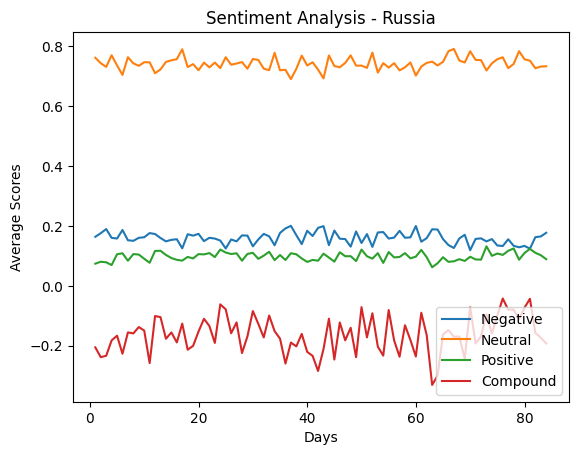

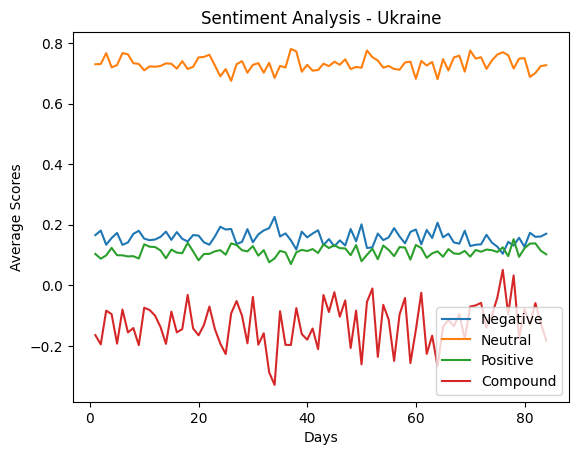

In [3]:
import ast
import matplotlib.pyplot as plt

def parseSentimentScores(line):
    sentiment_start = line.index("{'neg':")
    sentiment_end = line.index("},") + 1
    emotions_start = line.index("{", sentiment_end)
    emotions_end = line.index("};", emotions_start) + 1

    sentiment_scores = ast.literal_eval(line[sentiment_start:sentiment_end])
    emotions = ast.literal_eval(line[emotions_start:emotions_end])

    return sentiment_scores, emotions

def parseData(file):
    data = []
    for line in file:
        line = line.strip()
        if line:
            tweet_end = line.index(",")
            tweet = line[:tweet_end]
            scores, emotions = parseSentimentScores(line)
            data.append((tweet, scores, emotions))
    return data

def calculateAverageScores(data):
    averages = []
    num_opinions = len(data)
    for i in range(0, num_opinions, 100):
        start_index = i
        end_index = min(i + 100, num_opinions)
        opinions = data[start_index:end_index]
        avg_scores = {
            'neg': sum(scores['neg'] for _, scores, _ in opinions) / len(opinions),
            'neu': sum(scores['neu'] for _, scores, _ in opinions) / len(opinions),
            'pos': sum(scores['pos'] for _, scores, _ in opinions) / len(opinions),
            'compound': sum(scores['compound'] for _, scores, _ in opinions) / len(opinions)
        }
        averages.append(avg_scores)
    return averages

def plotAverageScores(averages, title):
    days = range(1, len(averages) + 1)
    neg_scores = [avg_scores['neg'] for avg_scores in averages]
    neu_scores = [avg_scores['neu'] for avg_scores in averages]
    pos_scores = [avg_scores['pos'] for avg_scores in averages]
    compound_scores = [avg_scores['compound'] for avg_scores in averages]

    plt.plot(days, neg_scores, label='Negative')
    plt.plot(days, neu_scores, label='Neutral')
    plt.plot(days, pos_scores, label='Positive')
    plt.plot(days, compound_scores, label='Compound')

    plt.xlabel('Days')
    plt.ylabel('Average Scores')
    plt.title(title)
    plt.legend()
    plt.show()

def main():
    with open("sentimentScoresRussia.txt", "r", encoding="utf-8") as file:
        dataRussia = parseData(file)
        averagesRussia = calculateAverageScores(dataRussia)
        plotAverageScores(averagesRussia, 'Sentiment Analysis - Russia')

    with open("sentimentScoresUkraine.txt", "r", encoding="utf-8") as file:
        dataUkraine = parseData(file)
        averagesUkraine = calculateAverageScores(dataUkraine)
        plotAverageScores(averagesUkraine, 'Sentiment Analysis - Ukraine')

if __name__ == '__main__':
    main()

Teraz możemy powoli przechodzić do posumowania naszych wyników. Jak widać po danych wykresach wiele tweetów zostało odebranych jako neutralne, a negatywne i pozytywne mają podobne wartości. Jeśli chodzi zaś o compound dla danych dni ten wynik strasznie się wacha po 1 i po 2 stronie. Czasami wachania nastrojów są podobne, a czasami odwrotne, dzieje się tak ponieważ, kiedy jedna armia odnosiła jakiś sukces, jak wysadzenie danego mostu czy też przejęcie miasta to tam wyniki podskakiwały, a u 2 malały. Jeśli spojrzymy na te tweety to widać jak 1 strona często gęsto odnosi się źle do sojuszników 2 i vice-versa. Życzenie śmierci prezydentowi USA, a z 2 życzenie śmierci prezydentowi Białorusi. Jest to zapewne spodziewane zjawisko. Jeśli chodzi jeszcze o emocje to możemy zobaczyć iż one również są bardzo podobne. Ciekawe jest natomiast, że złość nie przewodzi tymi tweetami (5%), a bardziej strach, który wynosi ponad 30% u 1 i u 2 oraz smutek po 20%. Można też zobaczyć radość i niespodziewaność, ale to jest zapewne uzależnione od sukcesów danej armii.